# Data Set download 
만약 저장되어있으면 생략할 것. 

In [ ]:
import os
from requests import get
import urllib
from urllib.parse import urlparse

In [ ]:

#https://ctkim.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-urllib-%EB%AA%A8%EB%93%88#google_vignette
#https://developer0hye.tistory.com/648

url_list = []
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/000.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/001.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/002.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/003.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/004.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/005.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/006.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/007.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/008.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/009.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/010.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/groundtruth.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/md5sums.txt')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/netvlad_v100_datasets.tar.gz')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/pose.txt')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/queries_real.tar')
url_list.append('https://data.ciirc.cvut.cz/public/projects/2015netVLAD/Pittsburgh250k/readGt.m')

print(url_list)
print(urlparse(url_list[0]))
print(os.path.basename(url_list[0]))

download_dir = "./data/Pittsburgh250k/"
if not os.path.exists(download_dir):
    os.mkdir(download_dir)


for url in url_list:
    print(url)
    file_name = os.path.basename(url)
    full_path = os.path.join(download_dir,file_name)
    print(full_path)
    urllib.request.urlretrieve(url,full_path)


In [ ]:
#압축 풀기
import tarfile

file_list = os.listdir(download_dir)
file_list_tar = [file for file in file_list if file.endswith(".tar")]

for fname in file_list_tar:
    tar_path = os.path.join(download_dir, fname)
    print("extract:", tar_path)

    with tarfile.open(tar_path) as tar:
        tar.extractall(path=download_dir)

# Dataset Loading

아래 코드는 https://github.com/Nanne/pytorch-NetVlad 와, https://github.com/Relja/netvlad 를 검토하여 작성했습니다. 




## Header

In [14]:
#Torch Library
import torch
import timm
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data.dataset import Subset
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#Standard Library
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
from collections import namedtuple
import random

# cache library
import h5py

# Vector library
import faiss
import sklearn
from sklearn.neighbors import NearestNeighbors

## Data path, parsing
데이터의 경로 및 parsing  
            whichSet, dataset, dbImage, utmDb, qImage, 
            utmQ, numDb, numQ, posDistThr, 
            posDistSqThr, nonTrivPosDistSqThr

In [2]:
root_dir = './data/Pittsburgh250k/'
struct_dir = os.path.join(root_dir, 'netvlad_v100_datasets/datasets/')
queries_dir = os.path.join(root_dir, 'queries_real/')


def parse_dbStruct(structfile, dbPath):

    structfile
    dataset = structfile  #db의 이름을 넣기 위한 위치

    mat = loadmat(os.path.join(dbPath,structfile))

    matStruct = mat['dbStruct'].item()

    #debugging 용 출력
    print(len(matStruct))
    first_col = list(map(lambda x: x[0], matStruct))
    for i in range(len(matStruct)):
        print(f"matStruct[{i}] :{first_col[i]}")

    whichSet = matStruct[0].item()

    dbImage = [f[0].item() for f in matStruct[1]]  #이미지리스트
    utmDb = matStruct[2].T

    qImage = [f[0].item() for f in matStruct[3]] #쿼리 이미지
    utmQ = matStruct[4].T

    numDb = matStruct[5].item()
    numQ = matStruct[6].item()

    posDistThr = matStruct[7].item()  #25
    posDistSqThr = matStruct[8].item() #625 --> 25^2
    nonTrivPosDistSqThr = matStruct[9].item() #100 -->10^2

    return dbStruct(whichSet, dataset, dbImage, utmDb, qImage, 
        utmQ, numDb, numQ, posDistThr, 
        posDistSqThr, nonTrivPosDistSqThr)

dbStruct = namedtuple('dbStruct', ['whichSet', 'dataset', 
    'dbImage', 'utmDb', 'qImage', 'utmQ', 'numDb', 'numQ',
    'posDistThr', 'posDistSqThr', 'nonTrivPosDistSqThr'])

test = parse_dbStruct('pitts250k_train.mat',struct_dir)
print(test[1])

10
matStruct[0] :train
matStruct[1] :[array(['000/000021_pitch1_yaw1.jpg'], dtype='<U26')]
matStruct[2] :[585323.61300252 585323.61300252 585323.61300252 ... 584463.92173637
 584463.92173637 584463.92173637]
matStruct[3] :[array(['001/001381_pitch1_yaw1.jpg'], dtype='<U26')]
matStruct[4] :[585089.36032141 585089.36032141 585089.36032141 ... 584861.3359102
 584861.3359102  584861.3359102 ]
matStruct[5] :[91464]
matStruct[6] :[7824]
matStruct[7] :[25]
matStruct[8] :[625]
matStruct[9] :[100]
pitts250k_train.mat


In [3]:
#DataLoader 를 instantiation할때 사용할 transform 선언
def input_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
    ])



import itertools

# QueryDataset 생성시 triplet 구성을 위한 함수 
# 각 instance들을 batch 단위로 쌓아 올린다. 
def collate_fn(batch):

    batch = list(filter (lambda x:x is not None, batch))
    if len(batch) == 0 :
        return None,None,None,None
    
    query, positive, negatives, indices = zip(*batch)
    query = data.dataloader.default_collate(query)
    positive = data.dataloader.default_collate(positive)
    negCounts = data.dataloader.default_collate([x.shape[0] for x in negatives])
    negatives = torch.cat(negatives, 0)

    indices = list(itertools.chain(*indices))

    return query, positive, negatives, negCounts, indices


In [4]:
class WholeDatset(data.Dataset):

    def __init__(self, dbPath, stPath, qPath, structFile, transform=None, onlyDB=False):
        super().__init__()  #parent class 초기화용이나, 현재는 크게필요하지 않음. 
        self.input_transform = transform #tensor로 변환
        self.dbStruct = parse_dbStruct(structFile, stPath) #dataset에 대한 파일 읽기

        self.images = [os.path.join(dbPath, dbIm) for dbIm in self.dbStruct.dbImage]
        if not onlyDB:
            self.images += [os.path.join(qPath, qIm) for qIm in self.dbStruct.qImage]

        self.whichSet = self.dbStruct.whichSet  #train, test, val 중 하나
        self.dataset = self.dbStruct.dataset   # pittsburgh250k, 30k 등

        self.positives = None   #현재는 없음
        self.distances = None   #현재는 없음

    def __len__(self):
            return len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index])  #dataset의 이미지를 불러와 출력

        if self.input_transform:
            img = self.input_transform(img)  #tensor로 변환한다. 
        return img, index

    def getPositive(self):   #학습에선 사용하지 않음. 이후 Test/Evaluation에서 GT추출용으로 사용 
        
        #Data의 숫자가 크지 않아 sklearn으로 아직까지 가능할 듯.         
        if  self.positives is None:
            knn = NearestNeighbors(n_jobs=-1)
            knn.fit(self.dbStruct.utmDb)

            self.distances, self.positives = knn.radius_neighbors(self.dbStruct.utmQ,
                    radius=self.dbStruct.posDistThr)

        return self.positives


# Class instantiation

In [11]:
#Dataset과 DataLoader에서 재현성을 위해 random관련 함수에 seed를 설정한다. 
#https://velog.io/@junegood/Seed-%EA%B3%A0%EC%A0%95-%EA%B5%AC%ED%98%84-%EB%B0%A9%EB%B2%95-%EA%B0%80%EC%9D%B4%EB%93%9C

if torch.cuda.is_available():
    device = 'cuda'
else : 
    device = 'cpu'
print(torch.cuda.is_available())
print(device)

seed = 50
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda' :
    torch.cuda.manual_seed(seed)
else :
    pass


whole_train_set = WholeDatset(
    dbPath = root_dir,
    stPath = struct_dir,
    qPath = queries_dir,
    structFile= 'pitts250k_train.mat',
    transform=input_transform(),
    onlyDB=False
    )

True
cuda
50
10
matStruct[0] :train
matStruct[1] :[array(['000/000021_pitch1_yaw1.jpg'], dtype='<U26')]
matStruct[2] :[585323.61300252 585323.61300252 585323.61300252 ... 584463.92173637
 584463.92173637 584463.92173637]
matStruct[3] :[array(['001/001381_pitch1_yaw1.jpg'], dtype='<U26')]
matStruct[4] :[585089.36032141 585089.36032141 585089.36032141 ... 584861.3359102
 584861.3359102  584861.3359102 ]
matStruct[5] :[91464]
matStruct[6] :[7824]
matStruct[7] :[25]
matStruct[8] :[625]
matStruct[9] :[100]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([[[1.2214, 1.2214, 1.2214,  ..., 1.4783, 1.4954, 1.4954],
         [1.2214, 1.2214, 1.2214,  ..., 1.4783, 1.4954, 1.4954],
         [1.2043, 1.2043, 1.2043,  ..., 1.4783, 1.4954, 1.4954],
         ...,
         [0.1768, 0.1597, 0.1597,  ..., 0.8276, 0.8276, 0.8104],
         [0.2111, 0.1939, 0.2111,  ..., 0.8789, 0.8789, 0.8618],
         [0.2624, 0.2453, 0.2624,  ..., 0.8618, 0.8618, 0.8618]],

        [[1.4482, 1.4482, 1.4482,  ..., 1.6758, 1.6933, 1.6933],
         [1.4482, 1.4482, 1.4482,  ..., 1.6758, 1.6933, 1.6933],
         [1.4307, 1.4307, 1.4307,  ..., 1.6758, 1.6933, 1.6933],
         ...,
         [0.4153, 0.3978, 0.3978,  ..., 0.9405, 0.9405, 0.9230],
         [0.4503, 0.4328, 0.4503,  ..., 0.9930, 0.9930, 0.9755],
         [0.5028, 0.4853, 0.5028,  ..., 0.9755, 0.9755, 0.9755]],

        [[1.8557, 1.8557, 1.8557,  ..., 2.0997, 2.1171, 2.1171],
         [1.8557, 1.8557, 1.8557,  ..., 2.0997, 2.1171, 2.1171],
         [1.8383, 1.8383, 1.8383,  ..., 2.1171, 2.1346, 2.

(-0.5, 639.5, 479.5, -0.5)

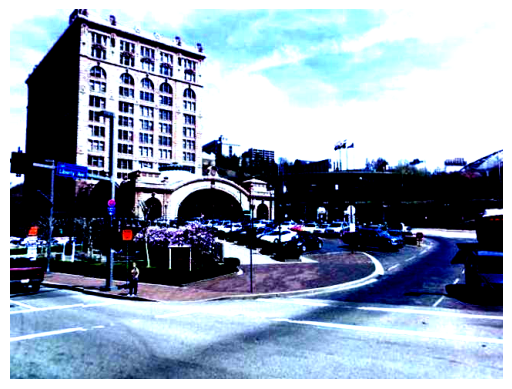

In [6]:
sample_img, sample_idx = whole_train_set[0]
print(sample_img)
print(sample_idx)
plt.imshow(sample_img.permute(1,2,0))
plt.axis('off')

In [7]:
whole_training_data_loader = DataLoader(
    dataset=whole_train_set,
    num_workers=8, 
    batch_size=24, 
    shuffle=False,
    pin_memory=True)

In [8]:
print(len(whole_training_data_loader))
print(whole_training_data_loader.num_workers)
print(whole_training_data_loader.dataset)

#https://noanomal.tistory.com/402
imgs, indices = next(iter(whole_training_data_loader))
print(imgs.shape)
print(indices.shape)


4137
8
torch.Size([24, 3, 480, 640])
torch.Size([24])


25
7824
length of Query :7824
./data/Pittsburgh250k/queries_real/002/002253_pitch2_yaw7.jpg
./data/Pittsburgh250k/001/001206_pitch1_yaw9.jpg
13.359838906149593


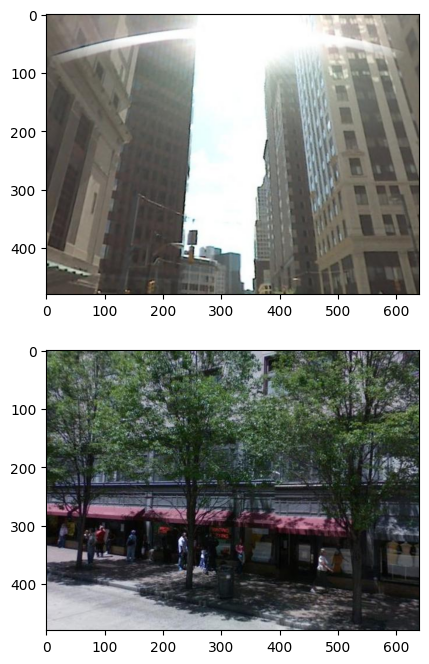

./data/Pittsburgh250k/queries_real/001/001669_pitch2_yaw7.jpg
./data/Pittsburgh250k/001/001490_pitch1_yaw4.jpg
21.62911931068043


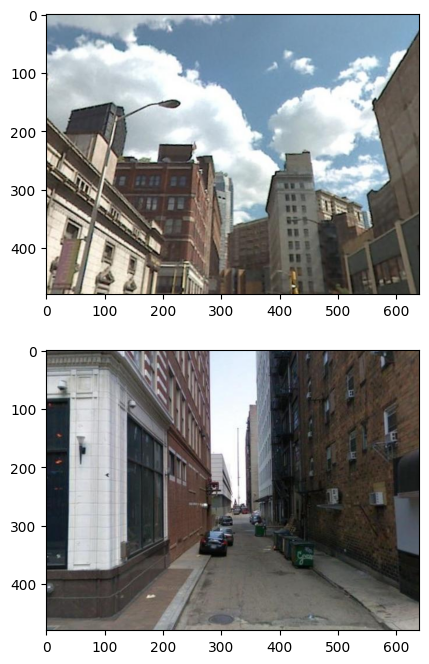

./data/Pittsburgh250k/queries_real/001/001413_pitch2_yaw9.jpg
./data/Pittsburgh250k/000/000595_pitch1_yaw5.jpg
14.965167363778308


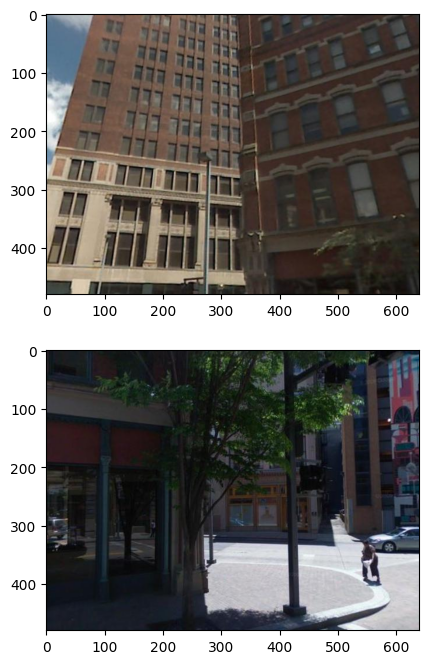

./data/Pittsburgh250k/queries_real/002/002734_pitch1_yaw4.jpg
./data/Pittsburgh250k/002/002010_pitch1_yaw2.jpg
20.51656290296443


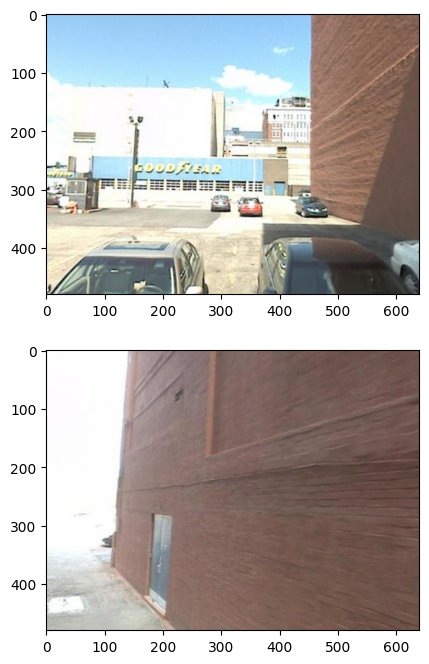

./data/Pittsburgh250k/queries_real/001/001632_pitch2_yaw11.jpg
./data/Pittsburgh250k/001/001270_pitch1_yaw1.jpg
18.836263940444162


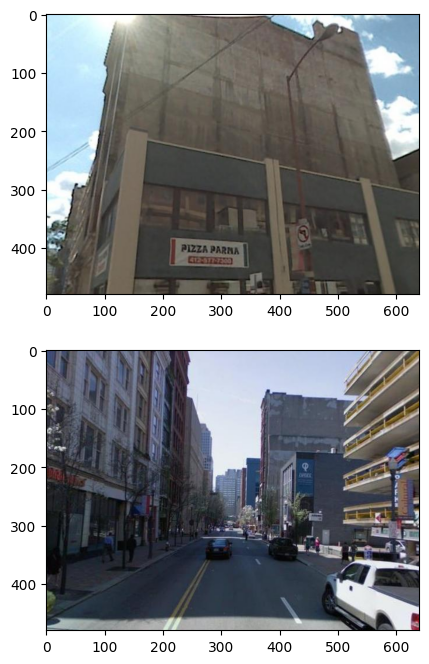

./data/Pittsburgh250k/queries_real/005/005709_pitch1_yaw5.jpg
./data/Pittsburgh250k/001/001837_pitch1_yaw12.jpg
20.131756812960028


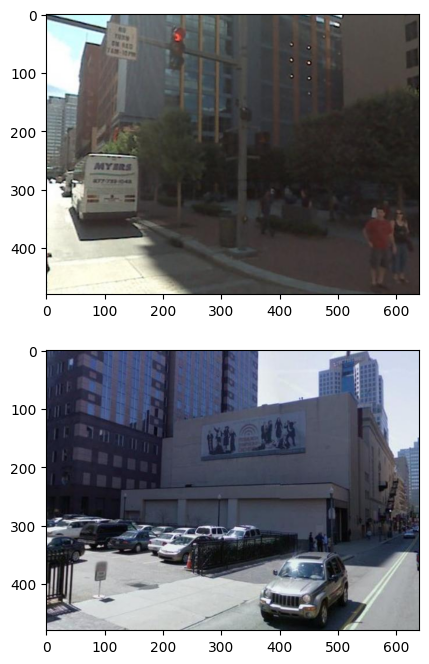

./data/Pittsburgh250k/queries_real/005/005518_pitch2_yaw1.jpg
./data/Pittsburgh250k/002/002070_pitch1_yaw3.jpg
24.373035593343417


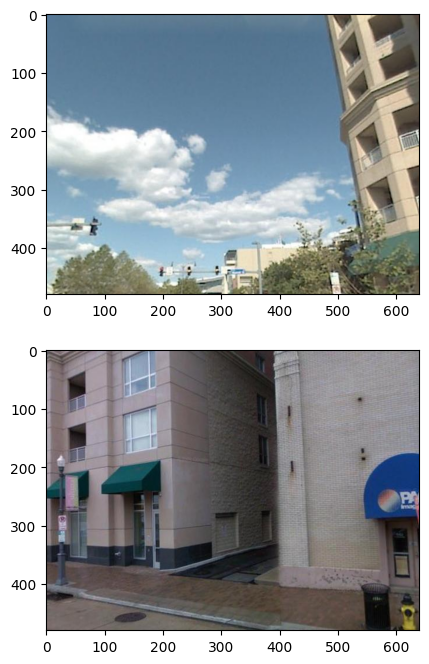

./data/Pittsburgh250k/queries_real/005/005781_pitch1_yaw6.jpg
./data/Pittsburgh250k/001/001432_pitch1_yaw9.jpg
14.682528615608652


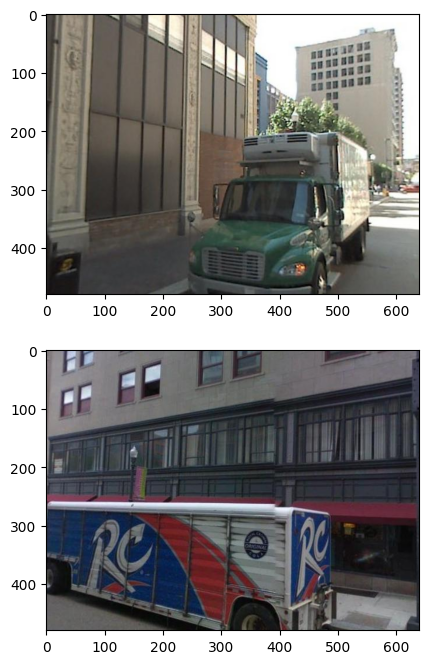

./data/Pittsburgh250k/queries_real/002/002291_pitch1_yaw12.jpg
./data/Pittsburgh250k/001/001206_pitch1_yaw9.jpg
22.62607257084727


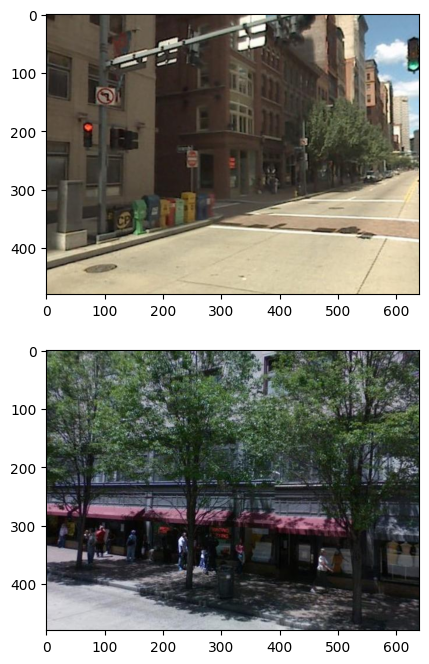

./data/Pittsburgh250k/queries_real/003/003095_pitch1_yaw2.jpg
./data/Pittsburgh250k/001/001142_pitch1_yaw1.jpg
14.198205541486415


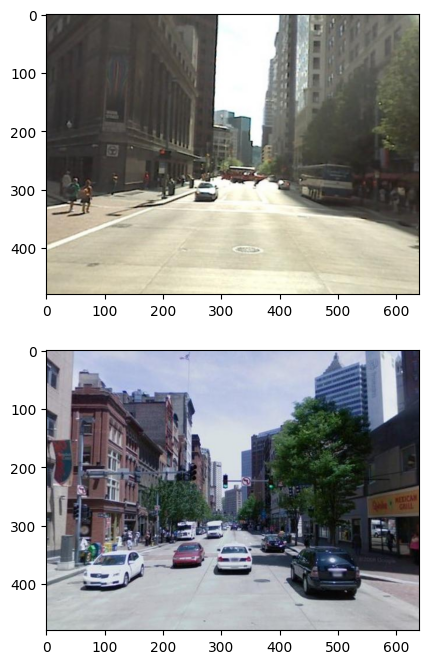

In [75]:
#알고리즘 테스트블럭임. 실행 안해도 문제없음.

knn_test = NearestNeighbors(n_jobs=-1)
knn_test.fit(whole_train_set.dbStruct.utmDb)

# 테스트를 위한 데이터셋 로딩
print(whole_train_set.dbStruct.posDistThr)
testPositiveDistance,testPositiveIndex = knn_test.radius_neighbors(whole_train_set.dbStruct.utmQ,
                                                                radius=whole_train_set.dbStruct.posDistThr,
                                                                return_distance=True
                                                                )
                                        

test_nontrivial_positives = []
        
for i in range(len(testPositiveIndex)):
            fDist = testPositiveDistance[i]
            nIndex = testPositiveIndex[i]
            fDistSq = fDist ** 2
            mask = fDistSq > whole_train_set.dbStruct.nonTrivPosDistSqThr
            test_nontrivial_positives.append(nIndex[mask])

test_pos_within_Thr = testPositiveIndex
test_nontrivial_pos = test_nontrivial_positives
# for item in nontrivial_positives_test[:5]:
#     print(item)

# print("sorted")
# for i, posi in enumerate(nontrivial_positives_test):
#     nontrivial_positives_test[i]=np.sort(posi)

# for item in nontrivial_positives_test[:5]:
#     print(item)

print(len(test_nontrivial_pos))
test_query = np.where(np.array([len(x) for x in test_nontrivial_pos])>0)[0]
print(f"length of Query :{len(test_query)}")


np.random.seed(10)
sample_q = np.random.choice(test_query, size=10, replace=False)

for i in sample_q:
    #쿼리 이미지 불러오기
    qIndex = test_query[i]  #테스트 쿼리 중 하나 불러오기. 
    qImg_path = os.path.join(queries_dir,whole_train_set.dbStruct.qImage[qIndex])
    print(qImg_path)
    q_img = Image.open(qImg_path)

    #db이미지 불러오기 
    dbIndex = test_nontrivial_positives[qIndex][0]
    dbImg_path = os.path.join(root_dir, whole_train_set.dbStruct.dbImage[dbIndex])
    print(dbImg_path)
    diff = whole_train_set.dbStruct.utmDb[dbIndex]-whole_train_set.dbStruct.utmQ[qIndex]
    print((diff @ diff) ** 0.5)
    db_img = Image.open(dbImg_path)

    #시각화
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.imshow(q_img)
    plt.subplot(2,1,2)
    plt.imshow(db_img)
    plt.show()

In [ ]:
class QueryDataset(data.Dataset):
    def __init__(self, stPath, structFile, dbPath=None, qPath=None,  transform = None, nNegSample = 1000, margin = 0.1, nNeg=10):
        #초반 구조는 wholedataset과 유사함.
        super().__init__()
        self.input_transform =  transform
        self.margin = margin

        self.dbStruct = parse_dbStruct(structFile, stPath)  #pittsburch250k_train.mat loading
        self.whichSet = self.dbStruct.whichSet              #train
        self.dataset = self.dbStruct.dataset                #pittsburch250k

        self.dbPath = dbPath  #사용하지는 않으나 파라미터 통일성을 위해 선언해둠.
        self.qPath = qPath    #사용하지는 않으나 파라미터 통일성을 위해 선언해둠.

        
        #Negative setup
        self.nNegSample = nNegSample # Negative의 샘플링 풀을 를 몇개로 할지 정함. 
        self.nNeg = nNeg


        # 초기에는 feature distance 값을 알 수 없으므로, 
        # __init__()에서 utm을 기반으로 하여 triplet을 구성한다. 

        #feature distance를 알 수 있는 단계에는 refresh_cache() 를 통해 업데이트한다. 
        #따라서, reference에 있는 __getitime__()에 있는 부분을 간략화 하고, 나머지는 refresh_cache로 이동한다.        
        
        # 각 Threshold의 설명 
        #  1) Trivial Pos : Positive중 Query와 너무 가까워서 제외되는 것들. < nontrivialPosDistSqThr
        #  2) nonTrivial Pos : nonTrivialPos~PosDisThr 사이에 존재하는 Positive들
        #  3) Negative : PosDistThr 밖의 좌표들

        # 참조 
        # posDistThr = matStruct[7].item()  #25
        # posDistSqThr = matStruct[8].item() #625 --> 25^2
        # nonTrivPosDistSqThr = matStruct[9].item() #100 -->10^2

        #Positive 검색을 위해 사전 작업
        #Positive는 dbImage에서 설정하므로, dbImage의 좌표값을 불러온다. 
        
        print("utmDb shape:", self.dbStruct.utmDb.shape, "utmQ shape:", self.dbStruct.utmQ.shape)

        knn = NearestNeighbors(n_jobs=8)
        knn.fit(self.dbStruct.utmDb)
        
        #거리 25m 이내의 positive 후보군들을 검색한다. 
        #기본 설정은 민코프스키 로 되어있으므로, 자동으로 유클리디안 거리가 나온다. 
        #여기서 의문은, trivial positive를 어떻게 제외하지 하는 부분이다. 
        PositiveDistance,PositiveIndex = knn.radius_neighbors(
            self.dbStruct.utmQ,
            radius=self.dbStruct.posDistThr,
            return_distance=True
            )
        
        nontrivial_positives = []
        
        for i in range(len(PositiveIndex)):
            fDist = PositiveDistance[i]
            nIndex = PositiveIndex[i]
            fDistSq = fDist ** 2
            mask = fDistSq > self.dbStruct.nonTrivPosDistSqThr
            #np masking 방법 https://m.blog.naver.com/baek2sm/221844619151
            nontrivial_positives.append(nIndex[mask])

        self.pos_within_Thr = PositiveIndex  #trivial 도 포함
        self.nontrivial_pos = nontrivial_positives 
        
        #예외처리를 위한 부분. 만약 nontrivial possitive가 없다면 해당 쿼리는 제외한다. 
        self.queries = np.where(np.array([len(x) for x in self.nontrivial_pos])>0)[0]

        # 인덱스만 가지고 하는데, 굳이 정렬할 이유가 있을까. 
        # for i, posi in enumerate(self.nontrivial_positives):
        #     self.nontrivial_positives[i]=np.sort(posi)
        
        # Negative 후보 만들기 
        self.potential_negatives = []

        # Index로 연산하기 위해 전체 Index를 하나 만든다. 
        self.numDbIndex = np.arange(self.dbStruct.numDb)
        
        
        #전체 dbImage 배열에서 Potential Positve를 뺀 나머지 배열을 만든다. 
        for pos in self.pos_within_Thr:
            self.potential_negatives.append(
                                            np.setdiff1d(
                                                         self.numDbIndex, pos, 
                                                         assume_unique=True
                                                         )
                                            )
            

        print(f"  numDb={self.dbStruct.numDb}, numQ={self.dbStruct.numQ}")
        print(f"  posDistThr={self.dbStruct.posDistThr} (m)")
        print(f"  nonTrivPosDistSqThr={self.dbStruct.nonTrivPosDistSqThr} (m^2)")
        print(f"  valid queries (nontrivial exists): {len(self.queries)}")

        sample_query = np.random.choice(self.queries,10,replace=False)
        for i in sample_query:
            print(f"Query : {i}, Nontrivial Pos : {len(self.nontrivial_pos[i])}, Negative : {len(self.potential_negatives[i])}")
        




        self.cache = None # filepath of HDF5 containing feature vectors for images

        self.negCache = [np.empty((0,)) for _ in range(self.dbStruct.numQ)]            

    #qFeature
    #dbFeature
    
    def refresh_cache(self):
        #리프레시 해야 할것. 

        return
    

    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self,index):
        index = self.queries[index]

        #반환할 Query image 

        #반환할 Positive imgae

        #반환할 Negative image(s) 설정상 1000개
        return index
    

In [71]:
ds = QueryDataset(stPath=struct_dir, structFile='pitts250k_train.mat')

10
matStruct[0] :train
matStruct[1] :[array(['000/000021_pitch1_yaw1.jpg'], dtype='<U26')]
matStruct[2] :[585323.61300252 585323.61300252 585323.61300252 ... 584463.92173637
 584463.92173637 584463.92173637]
matStruct[3] :[array(['001/001381_pitch1_yaw1.jpg'], dtype='<U26')]
matStruct[4] :[585089.36032141 585089.36032141 585089.36032141 ... 584861.3359102
 584861.3359102  584861.3359102 ]
matStruct[5] :[91464]
matStruct[6] :[7824]
matStruct[7] :[25]
matStruct[8] :[625]
matStruct[9] :[100]
  numDb=91464, numQ=7824
  posDistThr=25 (m)
  nonTrivPosDistSqThr=100 (m^2)
  valid queries (nontrivial exists): 7824
Query : 5514, Nontrivial Pos : 120, Negative : 91296
Query : 3242, Nontrivial Pos : 72, Negative : 91344
Query : 6291, Nontrivial Pos : 96, Negative : 91344
Query : 2006, Nontrivial Pos : 264, Negative : 91176
Query : 3840, Nontrivial Pos : 48, Negative : 91368
Query : 3468, Nontrivial Pos : 168, Negative : 91296
Query : 2076, Nontrivial Pos : 144, Negative : 91224
Query : 2292, Nontr


1. `wholedataset` 
  - pos_within_thr  : Test/Eval 용
  - nontrivial_pos  : Train 용
  - potential_negatives

2. define Network  

3. first run  
  - model.eval() + torch.no_grad()  
  - store feature vector of images (query, db)

3. Tripletdataset mining
  - set triplet, 
    -- collate_fn (query, positive, negative(s))

4. Train Epoch, Feature Extraction, Train network
  - model.train()

5. back to #3. update Triplet, especially feature vector. 
   do loop until epoch is over

6. test 는 나중에. 